In [1]:
import sys
from pathlib import Path


PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

In [2]:
from src.gpt_download import download_and_load_gpt2
from src.utility import load_weights_into_gpt
from decoder_only_transformer.src.gpt_arch import GPTModel, generate_text_simple, generate
from decoder_only_transformer.src.tokenization_embeddings import text_to_token_ids, token_ids_to_text, create_dataloader_v1
from decoder_only_transformer.src.pretrain_model import train_model_simple
from decoder_only_transformer.src.utility import plot_losses
from src.fine_tune_classification import train_classifier_simple, SpamDataset, random_split, create_balanced_dataset, calc_accuracy_loader, calc_loss_loader, plot_values, classify_review

2025-12-25 13:51:59.615148: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-25 13:51:59.663087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-25 13:52:00.817313: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/erna/venv/dev_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: Fut

In [3]:
import tiktoken
import torch
tokenizer = tiktoken.get_encoding("gpt2")

In [4]:
data_file_path = "data/SMSSpamCollection.tsv"

In [5]:
import pandas as pd
df = pd.read_csv(
data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [7]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [8]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [9]:
train_df, validation_df, test_df = random_split(
balanced_df, 0.7, 0.1)

In [10]:
train_df.to_csv("data/classification/train.csv", index=None)
validation_df.to_csv("data/classification/validation.csv", index=None)
test_df.to_csv("data/classification/test.csv", index=None)

In [11]:
train_dataset = SpamDataset(
csv_file="data/classification/train.csv",
max_length=None,
tokenizer=tokenizer
)
val_dataset = SpamDataset(
csv_file="data/classification/validation.csv",
max_length=train_dataset.max_length,
tokenizer=tokenizer
)
test_dataset = SpamDataset(
csv_file="data/classification/test.csv",
max_length=train_dataset.max_length,
tokenizer=tokenizer
)

In [12]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(
dataset=train_dataset,
batch_size=batch_size,
shuffle=True,
num_workers=num_workers,
drop_last=True,
)
val_loader = DataLoader(
dataset=val_dataset,
batch_size=batch_size,
num_workers=num_workers,
drop_last=False,
)
test_loader = DataLoader(
dataset=test_dataset,
batch_size=batch_size,
num_workers=num_workers,
drop_last=False,
)

In [13]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [15]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [16]:
BASE_CONFIG = {
"vocab_size": 50257,
"context_length": 1024,
"drop_rate": 0.0,
"qkv_bias": True
}

In [17]:
model_configs = {
"gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
"gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
"gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
"gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [18]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size, models_dir="model/gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: model/gpt2/124M/checkpoint
File already exists and is up-to-date: model/gpt2/124M/encoder.json
File already exists and is up-to-date: model/gpt2/124M/hparams.json
File already exists and is up-to-date: model/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: model/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: model/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: model/gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
in_features=BASE_CONFIG["emb_dim"],
out_features=num_classes
)

In [21]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [23]:
with torch.no_grad():
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In [24]:
import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
train_classifier_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=50,
eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.68 mi

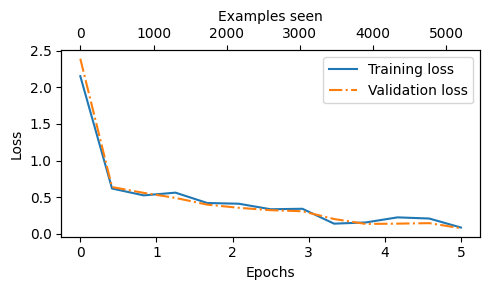

In [25]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

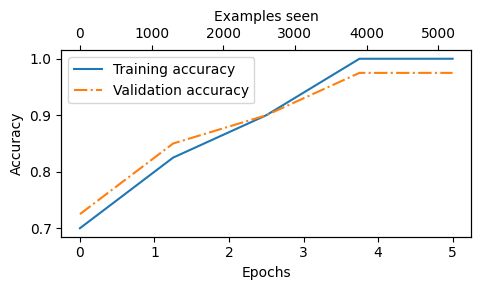

In [26]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
epochs_tensor, examples_seen_tensor, train_accs, val_accs,
label="accuracy"
)

In [27]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


In [28]:
text_1 = (
"You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [29]:
text_2 = (
"Hey, just wanted to check if we're still on"
" for dinner tonight? Let me know!"
)
print(classify_review(
text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [30]:
torch.save(model.state_dict(), "model/review_classifier.pth")